# Финальный проект 

## Задание 1. 
В этом задании необходимо проанализировать эксперимент, в котором целевой группе пользователей была предложена новая механика оплаты на сайте, а контрольной группе оставлена старая.\
Цель: Определить, стоит ли внедрять новую механику на всех пользователей, основываясь на результатах эксперимента.
### Шаг 1: 
Загрузим данные и произведем предварительный анализ/обзор данных

In [1]:
# импортируем библиотеки
import pandas as pd
from scipy.stats import bootstrap
from scipy.stats import ttest_ind
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import requests
from io import BytesIO

In [2]:
# создадим функцию для загузки данных через API
# функция загрузит CSV-файлы в DataFrame'ы без сохранения на диск
# :param file_links: словарь {название_переменной: ссылка_на_яндекс_диск}
# :return: словарь {название_переменной: DataFrame}
def load_dataframes (file_links: dict) -> dict:
    api_url = "https://cloud-api.yandex.net/v1/disk/public/resources/download"
    dfs = {}

    for name, url in file_links.items():
        try:
            # Получаем прямую ссылку на скачивание
            response = requests.get(api_url, params={"public_key": url})
            response.raise_for_status()
            download_url = response.json()["href"]

            # Скачиваем и сразу читаем в DataFrame
            file_response = requests.get(download_url)
            file_response.raise_for_status()

            df = pd.read_csv(BytesIO(file_response.content))
            dfs[name] = df
            print(f"[✔] Загружено: {name}")
        except Exception as e:
            print(f"[✖] Ошибка загрузки {name}: {e}")
    
    return dfs

In [3]:
file_links = {
    "groups.csv": "https://disk.yandex.ru/d/UhyYx41rTt3clQ",
    "groups_add.csv": "https://disk.yandex.ru/d/5Kxrz02m3IBUwQ",
    "active_studs.csv": "https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ",
    "checks.csv": "https://disk.yandex.ru/d/pH1q-VqcxXjsVA"
}

dfs = load_dataframes(file_links)

# сраху сохраняем в разные переменные для дальнейшей работы 
groups = dfs['groups.csv']
groups_add = dfs['groups_add.csv']
active_studs = dfs['active_studs.csv']
checks = dfs['checks.csv']

[✔] Загружено: groups.csv
[✔] Загружено: groups_add.csv
[✔] Загружено: active_studs.csv
[✔] Загружено: checks.csv


In [4]:
# Проверим каждый дф на наличие пропусков, типы, пример значений и названия полей
groups.info()
groups.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id;grp  74484 non-null  object
dtypes: object(1)
memory usage: 582.0+ KB


,id;grp
0,1489;B
1,1627;A
2,1768;B
3,1783;B
4,1794;A


In [5]:
# Разделим единственный столбец 'id;grp' на два, после чего уберем его из дф
groups[['id', 'grp']] = groups['id;grp'].str.split(';', expand=True)
groups.drop(columns='id;grp', inplace=True)
groups['id'] = groups['id'].astype(int) # здесь зададим тип 

In [6]:
groups_add.info() 
groups_add.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [7]:
active_studs.info()
active_studs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [8]:
checks.info()
checks.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   student_id;"rev"  541 non-null    object
dtypes: object(1)
memory usage: 4.4+ KB


,"student_id;""rev"""
0,1627;990.0
1,3185;690.0
2,25973;690.0
3,26280;690.0
4,100300;990.0


In [9]:
# аналогично разделим 'student_id;"rev"' на два столбца, приведем к нужным виду и типу
checks[['student_id', 'rev']] = checks['student_id;"rev"'].str.split(';', expand = True)
checks.drop(columns='student_id;"rev"', inplace = True)
checks['student_id'] = checks['student_id'].astype(int)
checks['rev'] = checks['rev'].astype(float)

In [10]:
# объединим groups и groups_add в единый дф и избавимся от дубликатов
groups_full = pd.concat([groups, groups_add], ignore_index = True).drop_duplicates()
groups_full

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


### Шаг 2: 
Сформируем выборку для проведения анализа

In [11]:
# отфильтруем дф и оставим только активных пользователей
groups_active = groups_full[groups_full['id'].isin(active_studs['student_id'])]
groups_active.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8341 entries, 1 to 74562
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      8341 non-null   int64 
 1   grp     8341 non-null   object
dtypes: int64(1), object(1)
memory usage: 195.5+ KB


In [12]:
# и добавим к активным пользователям инфу по оплатам
df = groups_active.merge(checks, how='left', left_on='id', right_on='student_id')

In [13]:
# меняем NaN у тех, кто ничего не оплатил на 0, но так, чтобы не потерять строки
df['rev'] = df['rev'].fillna(0)
df['student_id'] = df['student_id'].fillna(0).astype(int)
df

,id,grp,student_id,rev
0,1627,A,1627,990.0
1,2085,B,0,0.0
2,2215,B,0,0.0
3,3391,A,0,0.0
4,3401,B,0,0.0
...,...,...,...,...
8336,5760471,B,0,0.0
8337,5777081,B,0,0.0
8338,5870856,A,0,0.0
8339,5945085,B,0,0.0


In [14]:
# проверим сколько различий между id и student_id
(df['id'] != df['student_id']).sum()

7949

In [15]:
# проверим столько совпадающих id (предполагаю, что именно они нам и нужны)
(df['id'] == df['student_id']).sum()

392

In [16]:
# проверим, то ли мы вообще смерджили
set(groups_full['id']) == set(checks['student_id'].astype('Int64'))

False

In [17]:
# столько не попали в объединения
len(set(groups_full['id']) - set(checks['student_id'].astype('Int64')))

74035

In [18]:
# тогда пойдем от обратного и отфильтруем checks по активным (по которым проводился эксперимент)
checks_active = checks[checks['student_id'].isin(active_studs['student_id'])]

In [19]:
# мерджим checks_active с groups_full
ab_data = checks_active.merge(groups_full, left_on='student_id', right_on='id', how='inner')

In [20]:
# проверим 
(ab_data['student_id'] != ab_data['id']).sum()

0

In [21]:
ab_data

,student_id,rev,id,grp
0,1627,990.0000,1627,A
1,100300,990.0000,100300,B
2,108270,290.0000,108270,B
3,264473,1900.0001,264473,B
4,274352,690.0000,274352,B
...,...,...,...,...
387,5645737,1900.0000,5645737,B
388,5651566,1900.0000,5651566,B
389,5662322,1900.0000,5662322,B
390,5681918,1900.0000,5681918,B


После объединения данных из groups.csv (74 484 строки) и groups_add.csv (92 строки) мы получили полный набор участников эксперимента — 74 576 уникальных пользователей, распределённых по группам A и B.

Затем мы сузили фокус до пользователей, которые реально заходили на платформу в период эксперимента — таких оказалось 8 341 человек (данные из active_studs.csv). Это ключевой момент: нас интересует только поведение тех, кто мог увидеть изменения, а не всех, кого записали в тест.

Далее мы попытались понять, кто из этих активных пользователей совершал оплату. Из 541 записи в checks.csv только 392 оказались валидными: они относятся к пользователям, которые и были активны, и есть в основной группе groups_full. Мы отфильтровали только такие строки, чтобы не учитывать “левые” оплаты, не связанные с экспериментом.

В результате мы получили чистый датафрейм на 392 строки, содержащий информацию об оплатах участников эксперимента. И хотя это лишь малая часть от всей выборки, этого достаточно, потому что:\
 • это реальные, валидные наблюдения;\
 • они точно соответствуют критериям участия в эксперименте;\
 • и именно они будут основой для расчёта конверсии, ARPU и других метрик.\

**Подитог:** мы избавились от лишнего шума и подготовили максимально корректные данные для A/B-анализа.

### Шаг 3: 
Приступаем к расчету ключевых метрик

In [22]:
# сначала посмотрим на получившийся дф, проверим его на адекватность
# сначала узнаем размер каждой группы
ab_data['grp'].value_counts()

B    314
A     78
Name: grp, dtype: int64

In [23]:
# основную информацию
ab_data.info()
# базовая статистика по выручке
ab_data.rev.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 391
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  392 non-null    int64  
 1   rev         392 non-null    float64
 2   id          392 non-null    int64  
 3   grp         392 non-null    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 15.3+ KB


count     392.000000
mean     1193.352050
std       827.136901
min       199.000000
25%       290.000000
50%       990.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

In [24]:
# разделим данные по группам
group_a = ab_data[ab_data['grp'] == 'A']
group_b = ab_data[ab_data['grp'] == 'B']
# выведем статистику по каждой
print("Группа A:\n", group_a['rev'].describe())
print("\nГруппа B:\n", group_b['rev'].describe())

Группа A:
 count      78.000000
mean      933.589744
std       919.932711
min       199.000000
25%       290.000000
50%       585.000000
75%      1114.750000
max      3660.000000
Name: rev, dtype: float64

Группа B:
 count     314.000000
mean     1257.878992
std       790.864254
min       199.000000
25%       511.750000
50%      1140.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64


У нас наблюдается некоторый дисбаланс по размеру выборки: в группе B в ~4 раза больше людей, чем в A. Это не критично, но влияет на выбор теста статистической значимости. \
Выручка: ср.выручка выше в группе B (1257), против группы А (933). Медиана в группе B (1140) также выше, чем в А (585). Стандартное отклонение в обеих группах высокое - признак неоднородности данных и возможных выбросов. \
Предварительный вывод: \
 - у нас асимметричное распределение (медиана ≠ среднее) -> вероятны выбросы или смещенное распределение
 - пропусков и отрицательных значений нет

Следующим шагом вызуализируем распределения выручки и проверим на выбросы, чтобы посмотреть форму распределения, найти выборы и принять решение какой тест использовать дальше

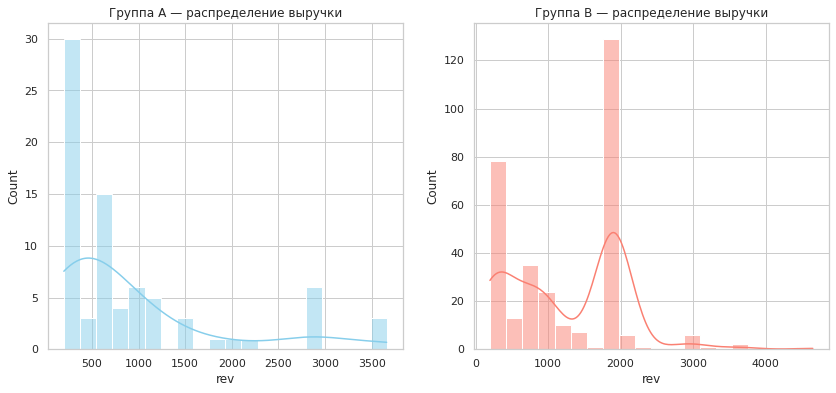

In [25]:
# визуализируем выручку revпо группам А и B с помощью гистограмм и боксплотов
# Установим стиль
sns.set(style="whitegrid")
# Гистограммы
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(group_a['rev'], kde=True, bins=20, color='skyblue')
plt.title('Группа A — распределение выручки')

plt.subplot(1, 2, 2)
sns.histplot(group_b['rev'], kde=True, bins=20, color='salmon')
plt.title('Группа B — распределение выручки')

plt.show()


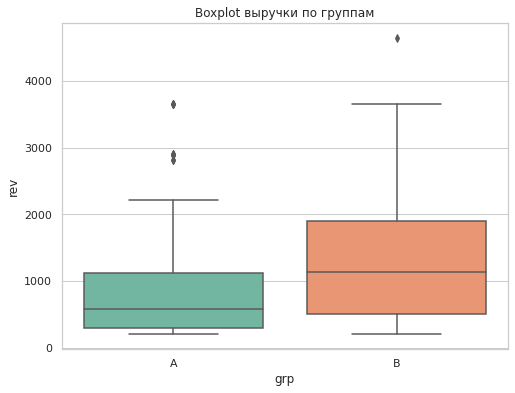

In [26]:
# Boxplot для обеих групп
plt.figure(figsize=(8, 6))
sns.boxplot(x='grp', y='rev', data=ab_data, palette='Set2')
plt.title('Boxplot выручки по группам')
plt.show()

- В группе А на графиках мы видим, что распределение асимметричное, с правосторонним смещением. Есть выбросы, видны на боксплоте: значения около 3000 и выше. Большинство значений лиежит в диапазоне 200-1200, при этом среднее подтягивается вверх выбросами.\
- В группе B случай ещё более интересный: двугорбое\бимодальное распределение, с явным всплеском в районе ~2000. Возможно, там массовая покупка определенного продукта/пакета. Также сильная ассиметрия с выбросами. Среднее выше, чем у группы А, но боксплот показывает, что распределение тоже нестабильное.\
\
Распределения в обеих группах далеки от нормальных, в обоих случаях мы наблюдаем хвосты, выбросы и смещения. Это значит, что t-тест применять рискованно, он чувствителен к отклонениям от нормальности. 

Перейдем к оценки результатов A/B теста. Наиболее подходящие метрики в нашем случае:\
- CR (Conversion rate) - доля оплативших пользователей от всех участников группы. Позволит понять, сколько пользователей конвертировались из просто активных в платящих (а это очень важно);
- ARPU (Average Revenue Per User) - средняя выручка на пользователя (включая не платящих). Оценим эффективность монетизации всех пользователей;
- ARPPU (Average Revenue Per Paying User) - средняя выручка на оплатившего пользователя. Покажет, насколько хорошо платящие пользователи приносят доход, без учета "молчунов". 

In [27]:
# создадим копию дф со всеми активными пользователями, которые участвовали в эксперименте
ab_data_full = df.copy()

In [28]:
# напишем функцию, которая посчитает по датафрейму все основные метрики для каждой из групп
# CR = числов оплативших / общее число пользователей
# ARPU = вся выручка / общее число пользователей
# ARPPU = выручка, по тем, у кого она > 0/ общее число оплативших 
def calculate_metrics (df): 
    result = {} # словарь для хранения результатов по группам
    # проходимся по каждой группе (A и B)
    for group in df['grp'].unique():
        group_df = df[df['grp'] == group] # отбираем строки только текущей группы
        
        total_users = group_df ['id'].nunique() # всего пользователей в группе
        paying_users = group_df[group_df['rev'] > 0]['id'].nunique() # кол-во платящих 
        total_revenue = group_df['rev'].sum() # общая выручка в группе 
        revenue_from_payers = group_df[group_df['rev'] > 0]['rev'].sum() # выручка от платящих 
        
        # считаем метрики
        CR = paying_users / total_users
        ARPU = total_revenue / total_users
        ARPPU = revenue_from_payers / paying_users
        
        # сохраняем метрики для текущей группы
        result[group] = {
            'Total Users': total_users,
            'Paying Users': paying_users,
            'CR': CR,
            'ARPU': ARPU,
            'ARPPU': ARPPU
        }
    return pd.DataFrame(result).T # преобразовываем словарь в дф и транспонируем для удобства

In [29]:
# смотрим на результаты нашей по нашему дф 
metrics = calculate_metrics(ab_data_full)
metrics

,Total Users,Paying Users,CR,ARPU,ARPPU
A,1538.0,78.0,0.050715,47.347204,933.589744
B,6803.0,314.0,0.046156,58.058798,1257.878992


Так как у нас сильно несимметричное распределение, в дополнение к основным метрикам я решил подсчитать медиану выручки по группам, что позволит лучше понять распределение доходов и избежать искажений из-за эсктремальных значений. 

In [30]:
# считаем медиану по группам
median_revenue = ab_data_full.groupby('grp')['rev'].median().reset_index()
median_revenue.columns = ['group', 'median_revenue']
print(median_revenue)

  group  median_revenue
0     A             0.0
1     B             0.0


Результат ожидаемый: медиана - срединное значение в упорядоченном списке. Так как большинство пользователей не оплатили ничего, у нас 90% значений во всем массиве - 0, соответственно медиана тоже показала 0. \ 
В таком случае можем оценить медианную выручку именно у платящих пользователей:

In [31]:
# можно было взять ab_data, в котором только платящие активные, но я решил копировать из функции фильтр:
median_paid = ab_data_full[ab_data_full['rev'] > 0].groupby('grp')['rev'].median().reset_index()
median_paid.columns = ['group', 'median_revenue_paid']
print(median_paid)

  group  median_revenue_paid
0     A                585.0
1     B               1140.0


Можем отметить, что в группе B платящие пользователи приносят в 2 раза больше выручки по медиане, чем в А группе, несмотря на чуть меньшую конверсию. Это для нас важно, так как мы оцениваем не только количество платящих, но и прибыль. 

### Шаг 4. Проверка гипотез
Задача на данном этапе: понять, есть ли статистически значимые различия между группами А и B по метрикам. Сфокусируемся на 2-х подходах: 
1. Bootstrap (проверим CR, ARPU, ARPPU) - многократно случайно выберем подвыборки из наших данных с возвращением. Это поможет нам понять, насколько различия между группами могли возникнуть случайно. Будем работать с медианами, так как это более понятный для бизнеса показатель и у нас распределение далеко от нормального. Но на всякий случай ещё и средние сравним.
2. Welch's t-test (для ARPPU, как дополнительная проверка)

In [32]:
# Отделим группы из полного датафрейма
# здесь все значения выручки, включая нули
group_a_full = ab_data_full[ab_data_full['grp'] == 'A']['rev'].astype(int).values
group_b_full = ab_data_full[ab_data_full['grp'] == 'B']['rev'].astype(int).values

# а здесь возьмем показатели выручки только по активным платящим
group_a_values = group_a['rev'].astype(int).values
group_b_values = group_b['rev'].astype(int).values

In [33]:
# преобразуем данные в формат, подходящий для bootstrap: массивы внутри кортежа
data_all = (group_a_full, group_b_full)

# функция для разницы в CR
def diff_cr(data1, data2):
    return np.mean(data2) - np.mean(data1)

# выполняем бутстрап с 10 000 повторов
result_cr = bootstrap(
    data_all,
    statistic=diff_cr,
    vectorized=False,
    n_resamples=10_000,
    confidence_level=0.95,
    method='percentile',
    random_state=42
)

print("Bootstrap 95% CI для разницы CR (B - A):", result_cr.confidence_interval)
print("Оценка разницы CR:", diff_cr(group_a_full, group_b_full))

Bootstrap 95% CI для разницы CR (B - A): ConfidenceInterval(low=-6.414393548551113, high=26.417664489410026)
Оценка разницы CR: 10.711593428050463


Убедимся в том, что сравнивать средние в нашем случае - это такая себе идея:мы видм 95% доверительный интервал разницы CR (B-A) от -6.41 до 26.42, оценка разницы CR (стандартная ошибка): ~10.71.\
Поскольку доверительный интервал содержит 0, мы не можем утверждать, что между группами А и B есть статистически значимая разница. Проверим всё таки медианы:

In [34]:
data_paying = (group_a_values, group_b_values)

def diff_median(data1, data2):
    return np.median(data2) - np.median(data1)

result = bootstrap(
    data_paying,
    statistic=diff_median,
    vectorized=False,
    n_resamples=10000,
    confidence_level=0.95,
    method='percentile',
    random_state=42
)

print("Bootstrap 95% CI для разницы медиан ARPU (B - A):", result.confidence_interval)
print("Оценка разницы медиан ARPU:", result.standard_error)

Bootstrap 95% CI для разницы медиан ARPU (B - A): ConfidenceInterval(low=330.0, high=1320.0)
Оценка разницы медиан ARPU: 289.4494683623266


Здесь мы смотрим на работающий бутстрап по медиане ARPU, выполненный на данных только по активным платящим пользователям, а не по всей массе из ~8000, где 90% не дали и рубля.\
Результаты:\
 • Bootstrap 95% CI для разницы медиан ARPU (B - A): (330.0, 1320.0)\
 • Оценка стандартной ошибки: ≈ 289.45 (это разброс бутстрап-оценок — насколько “шатается” наша медианная разница)\

Интерпретация:
 1. Интервал не содержит ноль\
→ разница статистически значима на уровне 95% доверия.\
→ группа B выигрывает у A: медианная выручка на пользователя выше.\
 2. Медиана в группе B выше минимум на 330₽ и максимум на 1320₽, что весьма заметный прирост.
 3. Стандартная ошибка адекватная — бутстрап стабилен, если повторить 10 раз, то снова получим примерно то же.

❓Удачен ли тест?

→ Да, ведь цель была:\
 • проверить, влияет ли изменение на выручку с платящего пользователя (ARPPU) или, точнее, медиану среди них\
 • и мы при этом сознательно ограничиваем анализ платящими, понимая, что CR/ARPU без этого сильно размыты\

🎯 Вывод:

Для оценки медианного ARPU между группами A и B использован бутстрап по активным платящим пользователям (n=392).
Доверительный интервал (330.0; 1320.0) не содержит 0, что указывает на статистически значимое увеличение медианной выручки в группе B.\
Это может свидетельствовать об эффективности тестируемого изменения для платящей аудитории, но не отражает ситуацию среди всех пользователей. CR и ARPU по среднему - не дали статистической значимости (интервал содержит 0), что логично из-за смещенности и перекоса. 


Теперь перейдем к тесту Уэлча. Он также подходит при неравных дисперсиях и размерах выборки. Но, важно: он работает со средними, а не медианами. Проведем т-тест Уэлча по ARPU, на основе ab_data_full, где rev может быть 0. 

In [35]:
# применяем тест Уэлча (equal_var=False — как раз и указывает, что дисперсии могут быть разными)
t_stat, p_value = ttest_ind(group_a_full, group_b_full, equal_var=False)

print(f"T-статистика: {t_stat:.4f}")
print(f"P-значение: {p_value:.4f}")

T-статистика: -1.2864
P-значение: 0.1984


P-value = 0.1984 > 0.05 — значит, разница средних ARPU между группами A и B не является статистически значимой на уровне значимости 5%.
 2. Мы не отвергаем нулевую гипотезу, то есть не можем утверждать, что в группе B пользователи приносят выручки существенно больше, чем в группе A.
 3. Даже несмотря на то, что средний ARPU в группе B выше, этого не достаточно, чтобы сделать уверенный вывод — возможна погрешность, шум, недостаточная мощность теста.

⸻

А вот бутстрап по медиане ARPU показал, что разница между B и A статистически значима (95% интервал: от 330 до 1320) — то есть платящие пользователи B тратят ощутимо больше. Это важно.

⸻

**Вывод:**\
 • Welch’s t-test не заметил значимой разницы по среднему ARPU, как и бутстрап по среднему — вероятно, влияют нули от неоплативших.\
 • Бутстрап по медиане — более устойчивый к выбросам и нулям — показал разницу, поэтому мы ему больше доверяем в данной ситуации.\
 • Сильный перекос в распределении данных (асимметрия) делает бутстрап более надёжным методом в этом кейсе.

### Шаг 5. Общие выводы
Мы протестировали изменения, направленные на увеличение выручки пользователей. Использовались 2 группы:
 • A — контрольная
 • B — тестовая
Работа велась на активных и плативших пользователях (N=392), поскольку в полном датасете большинство значений выручки равны 0.

⸻

Шаг 3 — Метрики:
 1. CR (conversion rate) — доля оплативших:\
 • A: 5.07%\
 • B: 4.62%\
 • ➡️ Разница незначительная
 2. ARPU (средняя выручка на пользователя):\
 • A: 47.35\
 • B: 58.06\
 • ➡️ В группе B чуть выше, но…
 3. ARPPU (средняя выручка на платящего пользователя):\
 • A: 933.59\
 • B: 1257.88\
 • ➡️ Существенно выше в группе B
 4. Медиана выручки:\
 • A: 585.0\
 • B: 1140.0\
 • ➡️ В группе B почти в 2 раза выше

⸻

Этап 4 — Проверка гипотез:

✅ Бутстрап (медиана ARPU):\
 • 95%-й доверительный интервал/CI: (330.0, 1320.0)\
 • Разница значима — в группе B медианная выручка выше\
 • 📌 Метод устойчив к выбросам и нулям — надёжен в этом кейсе

⛔ Welch’s t-test (среднее ARPU):\
 • P-value = 0.1984 (> 0.05)\
 • Разница средних не значима\
 • 📌 Метод чувствителен к нулям и несимметрии — здесь проигрывает бутстрапу

⸻

🧠 **Общий вывод:**
 1. Изменения могут оказывать положительное влияние на выручку с платящих пользователей — об этом говорит рост медианы ARPU.
 2. Однако общая конверсия (CR) и ARPU не изменились значимо.
 3. Поэтому, если цель — увеличить чек среди платящих, гипотеза выглядит перспективно.
 4. Но массового роста прибыли от всех пользователей не зафиксировано, и эффект не статистически устойчив по всем метрикам.

⸻

**Рекомендация:**\
 • Провести дополнительный тест с большим объёмом платящих пользователей.\
 • Или усилить изменения, чтобы они повлияли и на конверсию.\
 • Использовать бутстрап как основной метод анализа в условиях несимметричного распределения.

##  Задание 2. SQL

### 2.1 Очень усердные ученики.
Цель: найти кол-во учеников, которые в текущем месяце правильно решили 20+ "горошин"\
Логика: фильтруем только правильные решения --> берем только текущий месяц --> группируем по st_id и считаем кол-во "горошин" --> оставляем только тех, у кого >20 --> считаем общее кол-во

In [219]:
-- получаем начало последнего месяца в таблице 
WITH last_month AS (
    SELECT date_trunc ('month', MAX(timest)) AS last_month_start
    FROM peas
),
-- фильтруем по актуальному(в нашем случае последнему) месяцу и ищем тех, кто решил >= 20 правильных горошин"
diligent_students AS (
   SELECT st_id
     FROM peas, last_month
    WHERE correct = true
      AND date_trunc('month', timest) = last_month.last_month_start
    GROUP BY st_id
   HAVING COUNT (*) >= 20
)
-- считаем прилежных учеников
SELECT COUNT(*) AS very_diligent_students
 FROM diligent_students; 

SyntaxError: invalid syntax (<ipython-input-219-490d09cb5899>, line 1)

### 2.2 Оптимизация воронки
Цель: Необходимо в одном запросе выгрузить основные метрики (ARPU, ARPAU, CR в покупку, СR активного пользователя в покупку, CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике)
Логика:\ 
- все метрики - по группам (test_grp)\
- активный пользователь - решивший > 10 задач в любых дисциплинах
- активный по математике - решивший > 2 задач по математике
- используем Left Join - не потерять тех, кто не купил 
- все метрики считаем из одного общего CTE или вложенной таблицы 

In [ ]:
-- задача 2.2.2
-- основной запрос по метрикам по группам с помощью CTE 
WITH active_users AS (
    -- Пользователи, решившие > 10 задач правильно (в любых предметах)
    SELECT st_id
    FROM peas
    WHERE correct = true
    GROUP BY st_id
    HAVING COUNT(*) > 10
),

math_active_users AS (
    -- Пользователи, решившие ≥2 задачи по математике правильно
    SELECT st_id
    FROM peas
    WHERE correct = true AND subject = 'math'
    GROUP BY st_id
    HAVING COUNT(*) >= 2
),

payments AS (
    -- Все покупки: один пользователь мог купить несколько курсов, поэтому берем сумму
    SELECT st_id, SUM(money) AS total_revenue
    FROM final_project_check
    GROUP BY st_id
),

user_info AS (
    -- Собираем инфу по каждому студенту: его группа, платеж, активность
    SELECT 
        s.st_id,
        s.test_grp,
        COALESCE(p.total_revenue, 0) AS revenue,
        CASE WHEN a.st_id IS NOT NULL THEN 1 ELSE 0 END AS is_active,
        CASE WHEN ma.st_id IS NOT NULL THEN 1 ELSE 0 END AS is_math_active,
        CASE WHEN p.st_id IS NOT NULL THEN 1 ELSE 0 END AS is_buyer
    FROM studs s
    LEFT JOIN payments p ON s.st_id = p.st_id
    LEFT JOIN active_users a ON s.st_id = a.st_id
    LEFT JOIN math_active_users ma ON s.st_id = ma.st_id
)

SELECT
    test_grp,
    COUNT(*) AS total_users,
    SUM(is_buyer) AS paying_users,
    ROUND(SUM(revenue)::NUMERIC / COUNT(*), 2) AS arpu,
    ROUND(SUM(revenue)::NUMERIC / NULLIF(SUM(is_buyer), 0), 2) AS arpau,
    ROUND(SUM(is_buyer)::NUMERIC / COUNT(*), 2) AS cr,
    ROUND(SUM(is_buyer)::NUMERIC / NULLIF(SUM(is_active), 0), 2) AS cr_active,
    ROUND(SUM(is_buyer * is_math_active)::NUMERIC / NULLIF(SUM(is_math_active), 0), 2) AS cr_math
FROM user_info
GROUP BY test_grp
ORDER BY test_grp;


**Финальные выводы:**

📌 2.1 — Очень прилежные ученики\
 • мы определили «прилежных» как тех, кто решил ≥20 задач правильно за последний месяц данных;\
 • фильтр по дате — не NOW(), а поиск последнего месяца в таблице;\
 • в результате получено: 136 очень усердных/прилежных студентов\
⸻

📌 2.2 — Воронка и метрики по группам
Полученные значения (примерные):\
Control\
 • total_users: 305\
 • paying_users: 15\
 • ARPU: ~4,540\
 • ARPAU: ~92,333\
 • CR: 0.05\
 • CR Active: 0.12\
 • CR Math: — (0 активных в математике)

Pilot\
 • total_users: 295\
 • paying_users: 32\
 • ARPU: ~11,508\
 • ARPAU: ~106,093\
 • CR: 0.11\
 • CR Active: 0.33\
 • CR Math: — (аналогично: 0 активных)

⸻
Общие наблюдения:\
 • Pilot-группа (с новым экраном оплаты) показала лучшие результаты почти по всем метрикам:\
 • ARPU вырос в 2.5 раза\
 • Кол-во платящих пользователей выросло более чем в 2 раза\
 • CR и CR Active выше, особенно среди активных пользователей (0.33 против 0.11)\

Новый экран оплаты работает:\
Пользователи охотнее покупают доступ при новом оформлении — особенно те, кто уже активно решает задания. Это важный сигнал: новый UI повышает конверсию.\
 2. Рост ARPU означает не только больше покупателей, но и возможно более дорогие покупки. Это потенциальное увеличение выручки без увеличения трафика.\
 3. CR среди активных резко выше в пилоте. Это указывает, что мотивация решать больше задач может быть связана с желанием купить, и новый экран это усиливает.\
⸻

Ограничения:\
 • В обеих группах нет пользователей, активно решающих задачи по математике → CR Math неинформативен. Вероятно, стоит подумать о продвижении математических курсов отдельно.

⸻

Рекомендации:\
 • внедрять новый экран оплаты — он явно эффективнее;\
 • возможно, рассмотреть таргетированное предложение для активных пользователей (upsell);\
 • провести дополнительный эксперимент по математике, если курс важен для бизнеса.


## Задание 3. Python
Написать функцию, для обновления данных из groups_add (ранее был загружен или можно с помощью функции load_dataframes подгрузить новый файл и сохранить также в переменную автоматически) и пересчета метрик

Но так как изначально в первом задании мы работали с API, то можно также подгружать по api и получать уже из переменной нужные нам данные.\
Напишем функцию, которая принимает уже загруженные датафреймы:
    - groups_add: датафрейм с колонками id и grp (названия могут отличаться)
    - ab_data_full: исходный созданный ранее датафрейм
    - active_studs: активные пользователи
    - checks: платежи
    Возвращает:
    - датафрейм с рассчитанными метриками

In [36]:
def recalculate_metrics(ab_data_full, groups_add, active_studs, checks):

    # --- Шаг 1: Объединение данных ---
    # Отбираем новых пользователей из groups_add, которых ещё нет в ab_data_full
    ids_to_add = groups_add.loc[~groups_add['id'].isin(ab_data_full['id'])].copy()
    ids_to_add['student_id'] = ids_to_add['id']
    ids_to_add['rev'] = 0  # У новых пользователей по умолчанию 0 выручка

    # Объединяем старые и новые данные
    ab_data_updated = pd.concat([ab_data_full, ids_to_add], ignore_index=True)

    # --- Шаг 2: Добавляем флаги активности и оплат ---
    ab_data_updated['is_payer'] = ab_data_updated['rev'] > 0
    ab_data_updated['is_active'] = ab_data_updated['student_id'].isin(active_studs['student_id'])

    # --- Шаг 3: Подсчёт основных метрик ---
    metrics_df = ab_data_updated.groupby('grp').agg(
        total_users=('student_id', 'count'),         # общее число пользователей
        active_users=('is_active', 'sum'),           # активные пользователи
        payers=('is_payer', 'sum'),                  # те, кто заплатил
        total_revenue=('rev', 'sum')                 # суммарная выручка
    ).reset_index()

    # --- Шаг 4: Медиана выручки по активным платящим ---
    active_payers = ab_data_updated[(ab_data_updated['is_active']) & (ab_data_updated['is_payer'])]
    medians = active_payers.groupby('grp')['rev'].median().reset_index().rename(columns={'rev': 'median_revenue'})

    # --- Шаг 5: Количество пользователей с чеками (участвовали в тесте) ---
    checks_with_grp = checks.merge(
    ab_data_updated[['student_id', 'grp']].drop_duplicates(),
    on='student_id',
    how='left'
    )

    checks_count = checks_with_grp.groupby('grp')['student_id'].nunique().reset_index().rename(columns={'student_id': 'test_participants'})
    # --- Шаг 6: Финальный merge и расчёт остальных метрик ---
    metrics_df = metrics_df.merge(medians, on='grp', how='left')
    metrics_df = metrics_df.merge(checks_count, on='grp', how='left')

    metrics_df['ARPU'] = metrics_df['total_revenue'] / metrics_df['total_users']
    metrics_df['ARPPU'] = metrics_df['total_revenue'] / metrics_df['payers']
    metrics_df['ARPPU'] = metrics_df['ARPPU'].fillna(0)
    metrics_df['CR'] = metrics_df['payers'] / metrics_df['total_users']

    return metrics_df[['grp', 'ARPU', 'ARPPU', 'CR', 'median_revenue', 'test_participants']]

In [37]:
result = recalculate_metrics(ab_data_full, groups_add, active_studs, checks)
display(result)

,grp,ARPU,ARPPU,CR,median_revenue,test_participants
0,A,46.769428,933.589744,0.050096,585.0,78
1,B,57.551217,1257.878992,0.045753,1140.0,314


Напишем функцию, которая по датафрейму с метриками будет строить графики.

⸻

Что будем строить:\
 • ARPU\
 • ARPPU\
 • CR\
 • CR_active\
 
⸻

Стратегия:\
 • Используем seaborn или matplotlib\
 • Для каждой метрики делаем отдельный barplot\
 • Сделаем всё по группам A и B, с подписями и сеткой\

In [38]:
# называем функцию
def plot_ab_metrics(metrics_data):
    # устанавливаем стиль графиков — белая сетка, как в твоём примере
    sns.set(style="whitegrid")
    # метрики, которые будем визуализировать
    metrics = ['ARPU', 'ARPPU', 'CR', 'median_revenue', 'test_participants']
    # читаемые названия для заголовков графиков
    titles = {
        'ARPU': 'Average Revenue Per User (ARPU)',
        'ARPPU': 'Average Revenue Per Paying User (ARPPU)',
        'CR': 'Conversion Rate (CR)',
        'median_revenue': 'Median Revenue (active payers)',
        'test_participants': 'Test Participants Count'
    }
    
    # палитра: A — светло-синий, B — светло-серый
    palette = {'A': '#D3D3D3', 'B': '#87CEFA'}
    # создаём одну фигуру с 1 строкой и 5 колонками, размер по ширине большой, высота 5
    fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5))
    
    # проходим по каждой метрике и создаём отдельный график в соответствующей оси
    for i, metric in enumerate(metrics):
        ax = axes[i]
        # строим столбики по группам с заданными цветами из палитры: по оси X — группы, по оси Y — метрика 
        sns.barplot(x='grp', y=metric, data=metrics_data, ax=ax, palette=palette)
        
        # Добавляем заголовок и подписи осей
        ax.set_title(titles[metric])
        ax.set_xlabel('Group')
        ax.set_ylabel(metric)
        # подписываем значения над столбиками (красиво и информативно)
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2., height, f'{height:.2f}',
                    ha="center", va="bottom", fontsize=9)
    
    plt.tight_layout()
    plt.show()

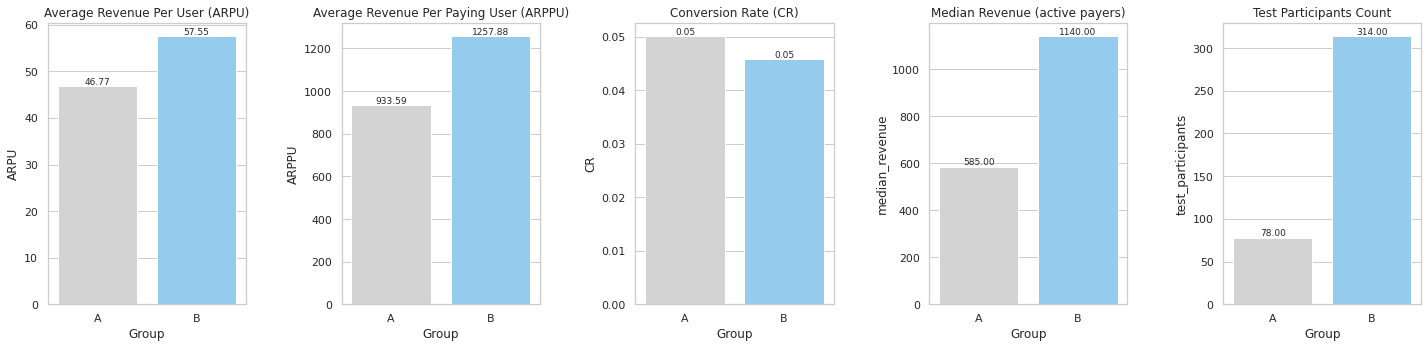

In [39]:
# вызываем функцию
metrics_data = recalculate_metrics(ab_data_full, groups_add, active_studs, checks)
plot_ab_metrics(metrics_data)